In [2]:
# Cell 1: 라이브러리 임포트 및 설정
import os
import torch
from PIL import Image
import numpy as np
import mlflow
from transformers import ViTImageProcessor, AutoModelForImageClassification
import matplotlib.pyplot as plt
import glob

# est_utils.py에서 필요한 함수 및 상수 임포트
from est_utils import correct_image_orientation, BACKBONE_CLASSES, FONT_PROP

# 추론 설정
config = {
    "mlflow_tracking_uri": "http://0.0.0.0:5000",
    "model_load_type": "mlflow_run_id", # "mlflow_run_id", "local_path", "base_model" 중 선택
    "mlflow_run_id": "f447303e4bf74f11b98907730ce08c99", # model_load_type이 "mlflow_run_id"일 경우 필요
    "local_model_path": "/workspace/AI/mlruns/1/models/m-8d2c3bcd04524f3aa4af1f7a4bd46f57/artifacts/", # model_load_type이 "local_path"일 경우 필요
    "base_model_name": "HardlyHumans/Facial-expression-detection", # model_load_type이 "base_model"일 경우 필요
    "inference_image_directory": "./Data/Google_search/" # 추론할 이미지가 있는 디렉토리
}

# MLflow 트래킹 서버 URI 설정
mlflow.set_tracking_uri(config["mlflow_tracking_uri"])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Cell 2: 모델 로딩 함수 (load_model_for_inference)
def load_model_for_inference(config, device):
    """
    설정된 방식에 따라 모델과 프로세서를 로드합니다.
    """
    model = None
    processor = None

    if config["model_load_type"] == "mlflow_run_id":
        try:
            model_uri = f"runs:/{config['mlflow_run_id']}/emotion_fine_tuned_model"
            model = mlflow.pytorch.load_model(model_uri)
            print(f"MLflow run_id: {config['mlflow_run_id']}에서 모델을 성공적으로 로드했습니다.")
        except Exception as e:
            print(f"MLflow 모델 로드 실패: {e}. 로컬 백본 모델로 폴백합니다.")
            config["model_load_type"] = "base_model" # 폴백

    if config["model_load_type"] == "local_path":
        try:
            model = mlflow.pytorch.load_model(config["local_model_path"])
            print(f"로컬 경로: {config['local_model_path']}에서 모델을 성공적으로 로드했습니다.")
        except Exception as e:
            print(f"로컬 경로 모델 로드 실패: {e}. 로컬 백본 모델로 폴백합니다.")
            config["model_load_type"] = "base_model" # 폴백

    if config["model_load_type"] == "base_model" or model is None:
        try:
            model = AutoModelForImageClassification.from_pretrained(config["base_model_name"])
            print(f"백본 모델 {config['base_model_name']}을 로드했습니다.")
        except Exception as e:
            print(f"백본 모델 로드 실패: {e}. 모델을 로드할 수 없습니다.")
            return None, None

    processor = ViTImageProcessor.from_pretrained(config["base_model_name"], use_fast=True)
    model.eval()
    model.to(device)
    return model, processor

In [ ]:
# Cell 3: 추론 함수 (perform_image_inference)
def perform_image_inference(image_path, model, processor, device, backbone_classes, correct_image_orientation_func):
    """
    단일 이미지에 대해 감정 추론을 수행하고 결과를 출력합니다.
    """
    try:
        image = Image.open(image_path)
        image = correct_image_orientation_func(image)
        image = image.convert("RGB")
        
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f'Image: {os.path.basename(image_path)}', fontproperties=FONT_PROP)
        plt.tight_layout()
        plt.show()
        
        inputs = processor(images=image, return_tensors="pt")
        inputs = {key: val.to(device) for key, val in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probabilities = torch.softmax(logits, dim=1).squeeze().cpu().numpy()

        print("\n==== 감정 분류 결과 ====")
        sorted_indices = np.argsort(probabilities)[::-1]
        
        for i in sorted_indices:
            emotion = backbone_classes[i]
            probability = probabilities[i]
            print(f"[{emotion}]: {probability:.4f}")

    except FileNotFoundError:
        print(f"오류: '{image_path}' 파일을 찾을 수 없습니다. 경로를 확인해 주세요.")
    except Exception as e:
        print(f"오류 발생: {e}")

MLflow run_id: f447303e4bf74f11b98907730ce08c99에서 모델을 성공적으로 로드했습니다.


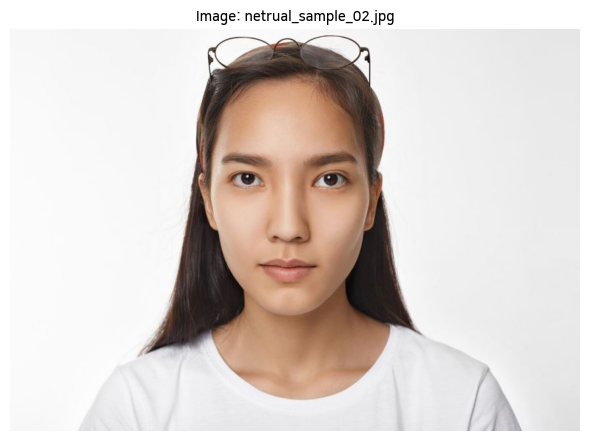


==== 감정 분류 결과 ====
[neutral]: 0.5148
[happy]: 0.3519
[anger]: 0.0328
[fear]: 0.0281
[sad]: 0.0273
[surprise]: 0.0261
[contempt]: 0.0189
[disgust]: 0.0002


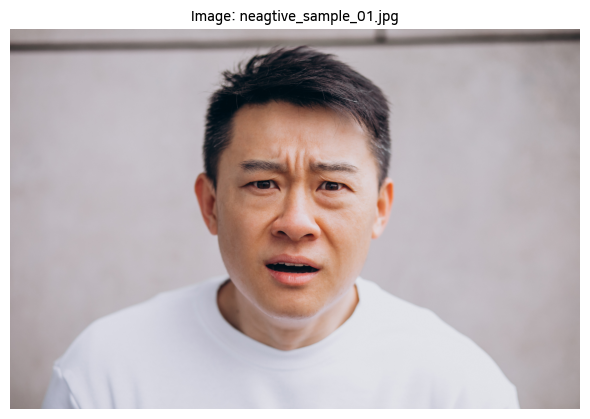


==== 감정 분류 결과 ====
[anger]: 0.2981
[neutral]: 0.2848
[fear]: 0.1560
[sad]: 0.1396
[surprise]: 0.1156
[happy]: 0.0048
[disgust]: 0.0008
[contempt]: 0.0004


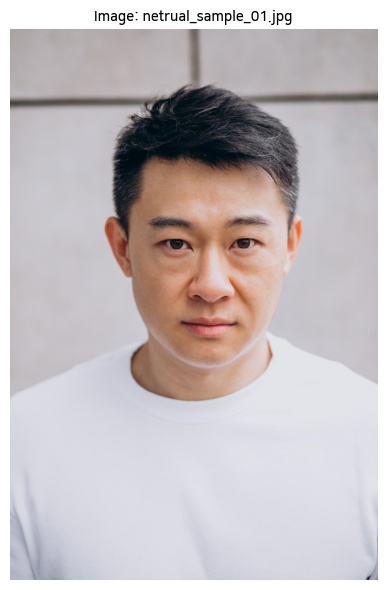


==== 감정 분류 결과 ====
[happy]: 0.5472
[neutral]: 0.2047
[anger]: 0.1464
[contempt]: 0.0411
[sad]: 0.0389
[fear]: 0.0174
[disgust]: 0.0025
[surprise]: 0.0018


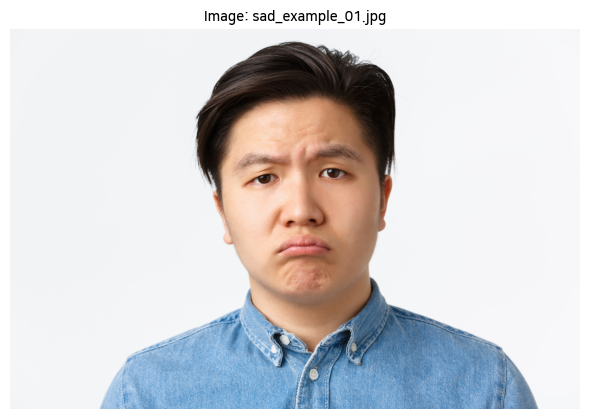


==== 감정 분류 결과 ====
[neutral]: 0.3763
[sad]: 0.2189
[fear]: 0.2032
[anger]: 0.1730
[surprise]: 0.0272
[disgust]: 0.0009
[happy]: 0.0003
[contempt]: 0.0002


In [10]:
# Cell 4: 메인 추론 루프
model, processor = load_model_for_inference(config, device)

if model and processor:
    image_paths = glob.glob(os.path.join(config['inference_image_directory'], '*.jpg')) + \
                  glob.glob(os.path.join(config['inference_image_directory'], '*.png')) + \
                  glob.glob(os.path.join(config['inference_image_directory'], '*.jpeg'))
    
    if not image_paths:
        print(f"경고: {config['inference_image_directory']} 디렉토리에서 이미지 파일을 찾을 수 없습니다.")
    
    for img_path in image_paths:
        perform_image_inference(img_path, model, processor, device, BACKBONE_CLASSES, correct_image_orientation)
else:
    print("모델 로드에 실패하여 추론을 수행할 수 없습니다.")